In [1]:
%matplotlib nbagg
%load_ext autoreload
%autoreload 2

from ProbabilisticDynamicsModel import *
from utils import *
import gym

/usr/local/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
env = gym.make('MountainCarContinuous-v0')

[2017-08-03 15:02:07,401] Making new env: MountainCarContinuous-v0


# Training the PDM
We randomly sample the state space of the problem for training data. However, rather than sampling the entire state space, we limit the sampling to within $x$ from $[-0.4, -0.09]$ to $[0.3,0.09]$, and $u$ from $[-0.5]$ to $[0.5]$

In [3]:
transitions = sample_transitions(env, [-0.4,-0.09], [0.3,0.09], [-0.5], [0.5], 5000)
# transitions = sample_transitions_rl('MountainCarContinuous-v0',1)

In [4]:
x_dim = transitions["x"].shape[1]
u_dim = transitions["u"].shape[1]

In [5]:
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth = True
sess = tf.Session(config = run_config)

pdm = LocallyLinearPDM(sess, x_dim, u_dim,
                       hidden_layer_sizes=[128],
                       dropout_prob=0.3,
                       num_mc_samples=50,
                       filename='ll_for_report',
                       writer_path='tf_logs')
pdm.build_model()

layer 0, shape [None, None, 128]


In [6]:
cfg = MLP_DM_cfg
cfg["lr"] = 5e-4
cfg["batch_size"] = 10
cfg["n_epochs"] = 90
cfg["store_val"] = False
with sess.as_default():
    pdm.train(transitions, cfg)

locallylinear_pdm Tensor("beta1:0", shape=(), dtype=float32)
Training with 3500 input/target pairs.
Epoch: [ 0] [   0/ 350] time: 0.0994, train_loss: 1.71833992, val_loss: 0.00000000
Saving checkpoint
Epoch: [ 0] [  10/ 350] time: 1.1182, train_loss: -4.51627684, val_loss: 0.00000000
Epoch: [ 0] [  20/ 350] time: 1.1656, train_loss: -4.59500074, val_loss: 0.00000000
Epoch: [ 0] [  30/ 350] time: 1.2135, train_loss: -3.96981287, val_loss: 0.00000000
Epoch: [ 0] [  40/ 350] time: 1.2600, train_loss: -2.80180264, val_loss: 0.00000000
Epoch: [ 0] [  50/ 350] time: 1.3061, train_loss: -1.53659725, val_loss: 0.00000000
Epoch: [ 0] [  60/ 350] time: 1.3630, train_loss: -0.06616211, val_loss: 0.00000000
Epoch: [ 0] [  70/ 350] time: 1.4141, train_loss: 0.02477932, val_loss: 0.00000000
Epoch: [ 0] [  80/ 350] time: 1.4635, train_loss: -3.64756489, val_loss: 0.00000000
Epoch: [ 0] [  90/ 350] time: 1.5061, train_loss: -3.64211178, val_loss: 0.00000000
Epoch: [ 0] [ 100/ 350] time: 1.5485, train_

# Compare to Nonlinear PDM

In [8]:
nlpdm = NonlinearPDM(sess, x_dim, u_dim,
                       hidden_layer_sizes=[128,128],
                       dropout_prob=0.3,
                       num_mc_samples=50,
                       filename='nl_for_report',
                       writer_path='tf_logs')
nlpdm.build_model()

layer 0, shape [None, None, 128]
layer 1, shape [None, None, 128]


In [9]:
with sess.as_default():
    nlpdm.train(transitions, cfg)

nonlinear_pdm Tensor("beta1_2:0", shape=(), dtype=float32)
Training with 3500 input/target pairs.
Epoch: [ 0] [   0/ 350] time: 0.0893, train_loss: -3.62249374, val_loss: 0.00000000
Saving checkpoint
Epoch: [ 0] [  10/ 350] time: 2.0253, train_loss: 0.60503006, val_loss: 0.00000000
Epoch: [ 0] [  20/ 350] time: 2.0626, train_loss: -2.93645477, val_loss: 0.00000000
Epoch: [ 0] [  30/ 350] time: 2.1039, train_loss: -6.65688705, val_loss: 0.00000000
Epoch: [ 0] [  40/ 350] time: 2.1451, train_loss: -5.16699886, val_loss: 0.00000000
Epoch: [ 0] [  50/ 350] time: 2.1849, train_loss: -5.52523804, val_loss: 0.00000000
Epoch: [ 0] [  60/ 350] time: 2.2226, train_loss: -0.80489922, val_loss: 0.00000000
Epoch: [ 0] [  70/ 350] time: 2.2653, train_loss: -1.15643120, val_loss: 0.00000000
Epoch: [ 0] [  80/ 350] time: 2.3059, train_loss: 1.40477753, val_loss: 0.00000000
Epoch: [ 0] [  90/ 350] time: 2.3469, train_loss: -4.32954884, val_loss: 0.00000000
Epoch: [ 0] [ 100/ 350] time: 2.3866, train_lo

# Comparing to Gaussian Process Model

In [10]:
gpdm = GaussianProcessDM(length_scale=1)
gpdm.build_model()
gpdm.train(transitions,cfg=None)

# Testing the Learned Model
We test the models on various slices of the state space 

<IPython.core.display.Javascript object>


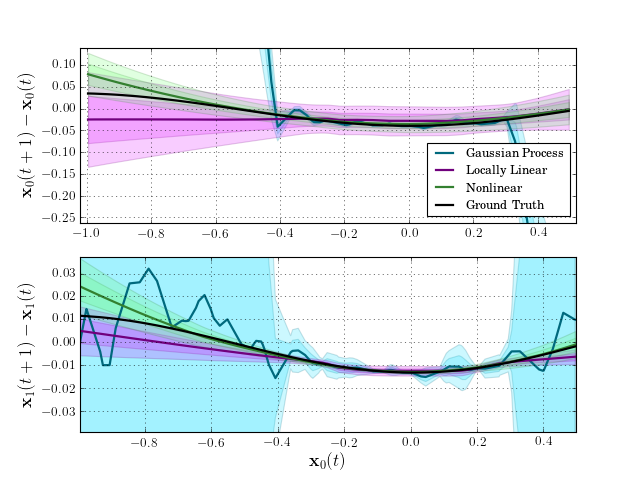

In [19]:
x_range = np.array([[-1, 0.0],[0.5, 0.0]])
u_range = np.array([[-0.1], [-0.1]])
sample_and_plot_results(env, [gpdm,nlpdm,pdm], x_range, u_range, labels=["Gaussian Process", "Locally Linear", "Nonlinear"])

<IPython.core.display.Javascript object>


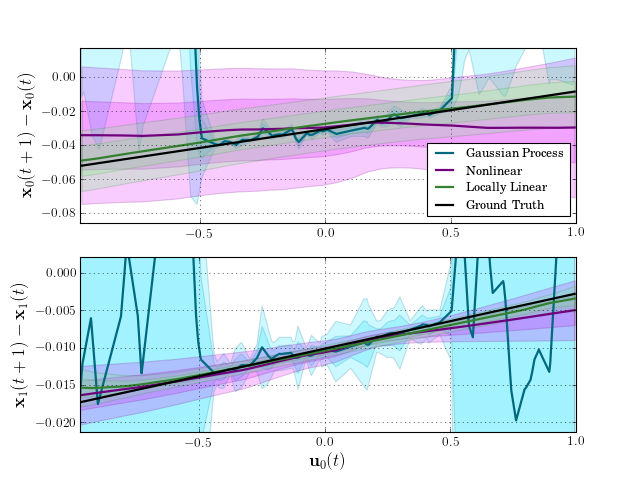

In [17]:
x_range = np.array([[-0.2, 0.00],[-0.2, 0.00]])
u_range = np.array([[-1], [1]])
sample_and_plot_results(env, [gpdm,nlpdm,pdm], x_range, u_range, labels=["Gaussian Process", "Nonlinear", "Locally Linear"])

<IPython.core.display.Javascript object>


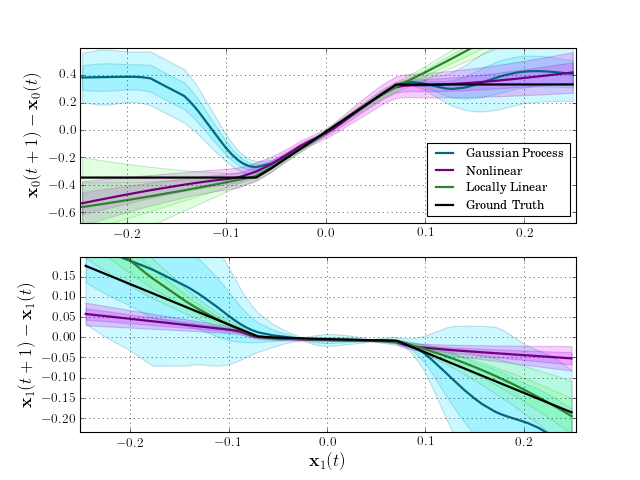

In [18]:
x_range = np.array([[-0.4, -0.25],[-0.4, 0.25]])
u_range = np.array([[-0.0], [-0.0]])
sample_and_plot_results(env, [gpdm,nlpdm,pdm], x_range, u_range, labels=["Gaussian Process", "Nonlinear", "Locally Linear"])

In [ ]:
gpdm.gpr.kernel_